<a href="https://colab.research.google.com/github/orekhovsky/GenAI-mini-projects/blob/main/RAG_text2sql/text2sql_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rouge-score -q

  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
from google.colab import userdata
df = pd.read_json("hf://datasets/Clinton/Text-to-sql-v1/texttosqlv2.jsonl", lines=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df

,instruction,input,response,source,text
0,Name the home team for carlton away team,CREATE TABLE table_name_77 (\n home_team VA...,SELECT home_team FROM table_name_77 WHERE away...,sql_create_context,Below are sql tables schemas paired with instr...
1,what will the population of Asia be when Latin...,"CREATE TABLE table_22767 (\n ""Year"" real,\n...","SELECT ""Asia"" FROM table_22767 WHERE ""Latin Am...",wikisql,Below are sql tables schemas paired with instr...
2,How many faculty members do we have for each g...,"CREATE TABLE Student (\n StuID INTEGER,\n ...","SELECT Sex, COUNT(*) FROM Faculty GROUP BY Sex...",nvbench,Below are sql tables schemas paired with instr...
3,List the record of 0-1 from the table?,CREATE TABLE table_14656147_2 (\n week VARC...,SELECT week FROM table_14656147_2 WHERE record...,sql_create_context,Below are sql tables schemas paired with instr...
4,"Which silver has a Gold smaller than 12, a Ran...",CREATE TABLE table_name_24 (\n silver VARCH...,SELECT silver FROM table_name_24 WHERE gold < ...,sql_create_context,Below are sql tables schemas paired with instr...
...,...,...,...,...,...
262203,Most viewed posts by tag w/o tag in post title.,"CREATE TABLE Comments (\n Id number,\n P...","SELECT Id AS ""post_link"", Tags, ViewCount, Cre...",sede,Below are sql tables schemas paired with instr...
262204,What is the time when ss12 is stage?,"CREATE TABLE table_24485 (\n ""Day"" text,\n ...","SELECT ""Time"" FROM table_24485 WHERE ""Stage"" =...",wikisql,Below are sql tables schemas paired with instr...
262205,count the number of patients whose year of dea...,CREATE TABLE demographic (\n subject_id tex...,SELECT COUNT(DISTINCT demographic.subject_id) ...,mimicsql_data,Below are sql tables schemas paired with instr...
262206,What was the styled used to defeat the opponen...,CREATE TABLE table_18598175_2 (\n method_of...,SELECT method_of_elimination FROM table_185981...,sql_create_context,Below are sql tables schemas paired with instr...


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import pandas as pd
import requests
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Функция для вызова модели через API
def generate_sql_code(instruction, table_schema, api_key):
    prompt = f"""
    You are an expert SQL query generator. Answer only with valid SQL code, nothing else.
    Instruction: {instruction}
    Table Schema: {table_schema}
    SQL code:
    """
    input_data = {
        "model": "meta-llama/llama-3.2-1b-instruct",
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )
    if response.status_code == 200:
        data = response.json()
        return data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Функция для вычисления метрик
def calculate_metrics(true_answer, model_response):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, model_response)

    true_tokens = true_answer.split()
    response_tokens = model_response.split()
    smooth_fn = SmoothingFunction().method1
    bleu_score = sentence_bleu([true_tokens], response_tokens, smoothing_function=smooth_fn)

    meteor = meteor_score([true_answer.split()], model_response.split())

    return bleu_score, meteor, rouge_scores['rouge1'].fmeasure, rouge_scores['rouge2'].fmeasure, rouge_scores['rougeL'].fmeasure

import sqlite3

def test_sql_query(table_schema, sql_query):
    try:
        # Создаем временную базу данных SQLite в памяти
        conn = sqlite3.connect(":memory:")
        cursor = conn.cursor()

        # Выполняем создание таблицы из схемы
        cursor.executescript(table_schema)

        # Выполняем сгенерированный SQL-запрос
        cursor.execute(sql_query)
        result = cursor.fetchall()

        # Закрываем соединение
        conn.close()

        return {"success": True, "result": result}
    except Exception as e:
        return {"success": False, "error": str(e)}

# Основной код
def evaluate_model(df, api_key, model_name="SQL Query Generator", summary_df=None):
    metrics_data = []  # Список для хранения строк данных
    for i, row in df.head(40).iterrows():  # Обрабатываем первые 40 строк
        instruction = row['instruction']
        table_schema = row['input']  # Используем описание таблицы
        true_response = row['response']

        try:
            # Генерация ответа модели
            model_response = generate_sql_code(instruction, table_schema, api_key)

            # Тестируем SQL-код
            test_result = test_sql_query(table_schema, model_response)
            sql_valid = test_result["success"]
            sql_error = test_result.get("error", "")

            # Вычисляем метрики
            bleu, meteor, rouge1, rouge2, rougeL = calculate_metrics(true_response, model_response)

            # Добавляем строку данных в список
            metrics_data.append({
                "Instruction": instruction,
                "Response": true_response,
                "Model Response": model_response,
                "BLEU": bleu,
                "METEOR": meteor,
                "ROUGE-1": rouge1,
                "ROUGE-2": rouge2,
                "ROUGE-L": rougeL,
                "SQL Valid": sql_valid,
                "SQL Error": sql_error
            })
        except Exception as e:
            print(f"Error processing row {i}: {e}")

    # Создаем датафрейм с метриками для каждого примера
    metrics_df = pd.DataFrame(metrics_data)

    # Рассчитываем средние значения метрик и процент правильных ответов
    average_bleu = metrics_df['BLEU'].mean()
    average_meteor = metrics_df['METEOR'].mean()
    average_rouge1 = metrics_df['ROUGE-1'].mean()
    average_rouge2 = metrics_df['ROUGE-2'].mean()
    average_rougeL = metrics_df['ROUGE-L'].mean()
    correct_responses_percentage = (metrics_df['SQL Valid'].sum() / len(metrics_df)) * 100

    # Создаем строку с метриками для текущей модели
    summary_data = {
        "Model": model_name,
        "Average BLEU": average_bleu,
        "Average METEOR": average_meteor,
        "Average ROUGE-1": average_rouge1,
        "Average ROUGE-2": average_rouge2,
        "Average ROUGE-L": average_rougeL,
        "Correct Responses (%)": correct_responses_percentage
    }

    # Если передан существующий summary_df, добавляем строку
    if summary_df is not None:
        summary_df = pd.concat([summary_df, pd.DataFrame([summary_data])], ignore_index=True)
    else:
        # Создаем новый датафрейм, если его нет
        summary_df = pd.DataFrame([summary_data])

    return metrics_df, summary_df

# Пример использования
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Допустим, ранее был создан summary_df
previous_summary_df = pd.DataFrame()

# Оцениваем новую модель и обновляем summary_df
metrics_df, summary_df = evaluate_model(df, OPENROUTER_API_KEY, model_name="llama-3.2-1b-instruct", summary_df=previous_summary_df)

# Результаты
summary_df



,Model,Average BLEU,Average METEOR,Average ROUGE-1,Average ROUGE-2,Average ROUGE-L,Correct Responses (%)
0,llama-3.2-1b-instruct,0.347761,0.647689,0.780819,0.640046,0.751439,0.0


In [ ]:
import pandas as pd
import requests
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Функция для вызова модели через API
def generate_sql_code(instruction, table_schema, api_key, model):
    prompt = f"""
    You are an expert SQL query generator. Answer only with valid SQL code, nothing else.
    Instruction: {instruction}
    Table Schema: {table_schema}
    SQL code:
    """
    input_data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )
    if response.status_code == 200:
        data = response.json()
        return data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Функция для вычисления метрик
def calculate_metrics(true_answer, model_response):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, model_response)

    true_tokens = true_answer.split()
    response_tokens = model_response.split()
    smooth_fn = SmoothingFunction().method1
    bleu_score = sentence_bleu([true_tokens], response_tokens, smoothing_function=smooth_fn)

    meteor = meteor_score([true_answer.split()], model_response.split())

    return bleu_score, meteor, rouge_scores['rouge1'].fmeasure, rouge_scores['rouge2'].fmeasure, rouge_scores['rougeL'].fmeasure

import sqlite3

def test_sql_query(table_schema, sql_query):
    try:
        # Создаем временную базу данных SQLite в памяти
        conn = sqlite3.connect(":memory:")
        cursor = conn.cursor()

        # Выполняем создание таблицы из схемы
        cursor.executescript(table_schema)

        # Выполняем сгенерированный SQL-запрос
        cursor.execute(sql_query)
        result = cursor.fetchall()

        # Закрываем соединение
        conn.close()

        return {"success": True, "result": result}
    except Exception as e:
        return {"success": False, "error": str(e)}

# Основной код
def evaluate_model(df, api_key, model="meta-llama/llama-3.2-1b-instruct", summary_df=None):
    metrics_data = []  # Список для хранения строк данных
    for i, row in df.head(40).iterrows():  # Обрабатываем первые 40 строк
        instruction = row['instruction']
        table_schema = row['input']  # Используем описание таблицы
        true_response = row['response']

        try:
            # Генерация ответа модели
            model_response = generate_sql_code(instruction, table_schema, api_key, model)

            # Тестируем SQL-код
            test_result = test_sql_query(table_schema, model_response)
            sql_valid = test_result["success"]
            sql_error = test_result.get("error", "")

            # Вычисляем метрики
            bleu, meteor, rouge1, rouge2, rougeL = calculate_metrics(true_response, model_response)

            # Добавляем строку данных в список
            metrics_data.append({
                "Instruction": instruction,
                "Response": true_response,
                "Model Response": model_response,
                "BLEU": bleu,
                "METEOR": meteor,
                "ROUGE-1": rouge1,
                "ROUGE-2": rouge2,
                "ROUGE-L": rougeL,
                "SQL Valid": sql_valid,
                "SQL Error": sql_error
            })
        except Exception as e:
            print(f"Error processing row {i}: {e}")

    # Создаем датафрейм с метриками для каждого примера
    metrics_df = pd.DataFrame(metrics_data)

    # Рассчитываем средние значения метрик и процент правильных ответов
    average_bleu = metrics_df['BLEU'].mean()
    average_meteor = metrics_df['METEOR'].mean()
    average_rouge1 = metrics_df['ROUGE-1'].mean()
    average_rouge2 = metrics_df['ROUGE-2'].mean()
    average_rougeL = metrics_df['ROUGE-L'].mean()
    correct_responses_percentage = (metrics_df['SQL Valid'].sum() / len(metrics_df)) * 100

    # Создаем строку с метриками для текущей модели
    summary_data = {
        "Model": model,
        "Average BLEU": average_bleu,
        "Average METEOR": average_meteor,
        "Average ROUGE-1": average_rouge1,
        "Average ROUGE-2": average_rouge2,
        "Average ROUGE-L": average_rougeL,
        "Correct Responses (%)": correct_responses_percentage
    }

    # Если передан существующий summary_df, добавляем строку
    if summary_df is not None:
        summary_df = pd.concat([summary_df, pd.DataFrame([summary_data])], ignore_index=True)
    else:
        # Создаем новый датафрейм, если его нет
        summary_df = pd.DataFrame([summary_data])

    return metrics_df, summary_df

# Пример использования
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Инициализация модели (меняется только здесь)
model_path = "deepseek/deepseek-chat"

# Оцениваем модель и получаем summary_df
metrics_df, summary_df = evaluate_model(df, OPENROUTER_API_KEY, model=model_path)

# Результаты
summary_df


,Model,Average BLEU,Average METEOR,Average ROUGE-1,Average ROUGE-2,Average ROUGE-L,Correct Responses (%)
0,deepseek/deepseek-chat,0.357821,0.649536,0.785041,0.645557,0.754927,0.0


# Сравнение моделей

In [ ]:
import pandas as pd
import requests
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Функция для вызова модели через API
def generate_sql_code(instruction, table_schema, api_key, model):
    prompt = f"""
    You are an expert SQL query generator. Answer only with valid SQL code, nothing else.
    Instruction: {instruction}
    Table Schema: {table_schema}
    SQL code:
    """
    input_data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )
    if response.status_code == 200:
        data = response.json()
        return data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Функция для вычисления метрик
def calculate_metrics(true_answer, model_response):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, model_response)

    true_tokens = true_answer.split()
    response_tokens = model_response.split()
    smooth_fn = SmoothingFunction().method1
    bleu_score = sentence_bleu([true_tokens], response_tokens, smoothing_function=smooth_fn)

    meteor = meteor_score([true_answer.split()], model_response.split())

    return bleu_score, meteor, rouge_scores['rouge1'].fmeasure, rouge_scores['rouge2'].fmeasure, rouge_scores['rougeL'].fmeasure

import sqlite3

def test_sql_query(table_schema, sql_query):
    try:
        # Создаем временную базу данных SQLite в памяти
        conn = sqlite3.connect(":memory:")
        cursor = conn.cursor()

        # Выполняем создание таблицы из схемы
        cursor.executescript(table_schema)

        # Выполняем сгенерированный SQL-запрос
        cursor.execute(sql_query)
        result = cursor.fetchall()

        # Закрываем соединение
        conn.close()

        return {"success": True, "result": result}
    except Exception as e:
        return {"success": False, "error": str(e)}

# Основной код
def evaluate_model(df, api_key, model_name="SQL Query Generator", summary_df=None):
    metrics_data = []  # Список для хранения строк данных
    for i, row in df.head(30).iterrows():  # Обрабатываем первые 30 строк
        instruction = row['instruction']
        table_schema = row['input']  # Используем описание таблицы
        true_response = row['response']

        try:
            # Генерация ответа модели
            model_response = generate_sql_code(instruction, table_schema, api_key, model_name)

            # Тестируем SQL-код
            test_result = test_sql_query(table_schema, model_response)
            sql_valid = test_result["success"]
            sql_error = test_result.get("error", "")

            # Вычисляем метрики
            bleu, meteor, rouge1, rouge2, rougeL = calculate_metrics(true_response, model_response)

            # Добавляем строку данных в список
            metrics_data.append({
                "Instruction": instruction,
                "Response": true_response,
                "Model Response": model_response,
                "BLEU": bleu,
                "METEOR": meteor,
                "ROUGE-1": rouge1,
                "ROUGE-2": rouge2,
                "ROUGE-L": rougeL,
                "SQL Valid": sql_valid,
                "SQL Error": sql_error
            })
        except Exception as e:
            print(f"Error processing row {i}: {e}")

    # Создаем датафрейм с метриками для каждого примера
    metrics_df = pd.DataFrame(metrics_data)

    # Рассчитываем средние значения метрик и процент правильных ответов
    average_bleu = metrics_df['BLEU'].mean()
    average_meteor = metrics_df['METEOR'].mean()
    average_rouge1 = metrics_df['ROUGE-1'].mean()
    average_rouge2 = metrics_df['ROUGE-2'].mean()
    average_rougeL = metrics_df['ROUGE-L'].mean()
    correct_responses_percentage = (metrics_df['SQL Valid'].sum() / len(metrics_df)) * 100

    # Создаем строку с метриками для текущей модели
    summary_data = {
        "Model": model_name,
        "Average BLEU": average_bleu,
        "Average METEOR": average_meteor,
        "Average ROUGE-1": average_rouge1,
        "Average ROUGE-2": average_rouge2,
        "Average ROUGE-L": average_rougeL,
        "Correct Responses (%)": correct_responses_percentage
    }

    # Если передан существующий summary_df, добавляем строку
    if summary_df is not None:
        summary_df = pd.concat([summary_df, pd.DataFrame([summary_data])], ignore_index=True)
    else:
        # Создаем новый датафрейм, если его нет
        summary_df = pd.DataFrame([summary_data])

    return metrics_df, summary_df

# Пример использования
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Список моделей для оценки
models = [
    "meta-llama/llama-3.2-1b-instruct",
    "deepseek/deepseek-chat",
    "qwen/qvq-72b-preview",
    "google/gemini-2.0-flash-thinking-exp:free",
    "sao10k/l3.3-euryale-70b"
]

# Инициализация пустого summary_df
summary_df = pd.DataFrame()

# Оценка всех моделей и добавление результатов в summary_df
for model in models:
    metrics_df, summary_df = evaluate_model(df, OPENROUTER_API_KEY, model_name=model, summary_df=summary_df)

# Результаты
summary_df


,Model,Average BLEU,Average METEOR,Average ROUGE-1,Average ROUGE-2,Average ROUGE-L,Correct Responses (%)
0,meta-llama/llama-3.2-1b-instruct,0.209649,0.479784,0.738945,0.559403,0.677429,46.666667
1,deepseek/deepseek-chat,0.400316,0.681937,0.809426,0.680252,0.771990,6.666667
2,qwen/qvq-72b-preview,0.005466,0.089474,0.036557,0.027601,0.035239,0.000000
3,google/gemini-2.0-flash-thinking-exp:free,0.037817,0.065801,0.077112,0.066963,0.075524,0.000000
4,sao10k/l3.3-euryale-70b,0.000000,0.000000,0.003704,0.000000,0.003704,0.000000


In [ ]:
metrics_df[metrics_df['SQL Valid'] == True]

,Instruction,Response,Model Response,BLEU,METEOR,ROUGE-1,ROUGE-2,ROUGE-L,SQL Valid,SQL Error


# Проверка датафрейма на наличие сложных схем

In [ ]:
df_for_test = df

# Считаем вхождения 'CREATE TABLE' в каждой строке
df_for_test['create_table_count'] = df_for_test['input'].str.count('CREATE TABLE')

# Находим максимальное значение
max_tables_in_one_line = df_for_test['create_table_count'].max()

# Находим индексы строк с максимальным значением
max_indices = df_for_test[df_for_test['create_table_count'] == max_tables_in_one_line].index.tolist()

print(f"Максимальное количество таблиц в одной строке: {max_tables_in_one_line}")
print(f"Индексы строк с максимальным значением: {max_indices}")


In [ ]:
len(max_indices)

10050

In [ ]:
# Опционально: вывод самих строк для проверки
if max_indices:
    print("\nСтроки с максимальным количеством таблиц:")
    print(df_for_test.loc[max_indices, ['input', 'create_table_count']])


Строки с максимальным количеством таблиц:
                                                input  create_table_count
46  CREATE TABLE ReviewTaskResults (\n    Id numbe...                  29
52  CREATE TABLE PendingFlags (\n    Id number,\n ...                  29
75  CREATE TABLE SuggestedEditVotes (\n    Id numb...                  29
96  CREATE TABLE ReviewTaskResultTypes (\n    Id n...                  29


In [ ]:
df_for_test['response'][46]

'SELECT s.DisplayName, s.Reputation AS RepSO, m.Reputation AS RepMath, (LOG10(s.Reputation) + LOG10(m.Reputation)) / 2 AS RepAvDigits FROM "stackexchange.math".Users AS m, "stackoverflow".Users AS s WHERE s.Reputation > 10000 AND m.Reputation > 10000 AND s.AccountId = m.AccountId ORDER BY 4 DESC'

In [ ]:
df_for_test.iloc[46]

,46
instruction,Users with highest reputation both in SO and M...
input,CREATE TABLE ReviewTaskResults (\n Id numbe...
response,"SELECT s.DisplayName, s.Reputation AS RepSO, m..."
source,sede
text,Below are sql tables schemas paired with instr...
create_table_count,29


# Формирование датафрейма, содержащего только непростые схемы

In [ ]:
df_for_RAG = df
df_for_RAG['create_table_count'] = df['input'].str.count('CREATE TABLE')
df_for_RAG = df_for_RAG[df_for_RAG['create_table_count']>10]
df_for_RAG.shape

(34261, 6)

In [ ]:
df_for_RAG

,instruction,input,response,source,text,create_table_count
6,what are the early morning flights from BOSTON...,"CREATE TABLE time_interval (\n period text,...",SELECT DISTINCT flight.flight_id FROM airport_...,atis,Below are sql tables schemas paired with instr...,25
27,How often does the course POLSCI 659 meet ?,"CREATE TABLE course (\n course_id int,\n ...","SELECT DISTINCT course_offering.friday, course...",advising,Below are sql tables schemas paired with instr...,18
38,"Next semester , what time does the EDUC 510 le...","CREATE TABLE area (\n course_id int,\n a...",SELECT DISTINCT course_offering.start_time FRO...,advising,Below are sql tables schemas paired with instr...,18
46,Users with highest reputation both in SO and M...,CREATE TABLE ReviewTaskResults (\n Id numbe...,"SELECT s.DisplayName, s.Reputation AS RepSO, m...",sede,Below are sql tables schemas paired with instr...,29
52,Ranking of questions by score.,"CREATE TABLE PendingFlags (\n Id number,\n ...","SELECT Posts.Id AS ""post_link"", Posts.Title, P...",sede,Below are sql tables schemas paired with instr...,29
...,...,...,...,...,...,...
262163,Give the number of departments with greater th...,"CREATE TABLE teaches (\n ID varchar(5),\n ...","SELECT building, COUNT(building) FROM departme...",nvbench,Below are sql tables schemas paired with instr...,11
262165,what was the top four most frequent diagnoses ...,CREATE TABLE d_icd_procedures (\n row_id nu...,SELECT d_icd_diagnoses.short_title FROM d_icd_...,mimic_iii,Below are sql tables schemas paired with instr...,17
262170,what were the four most frequent diagnoses tha...,CREATE TABLE inputevents_cv (\n row_id numb...,SELECT d_icd_diagnoses.short_title FROM d_icd_...,mimic_iii,Below are sql tables schemas paired with instr...,17
262175,what was patient 20165's weight the first time...,"CREATE TABLE chartevents (\n row_id number,...",SELECT chartevents.valuenum FROM chartevents W...,mimic_iii,Below are sql tables schemas paired with instr...,17


#Тест моделей на сложных схемах

In [ ]:
# Пример использования
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Список моделей для оценки
models = [
    "meta-llama/llama-3.2-1b-instruct",
    "deepseek/deepseek-chat",
    "qwen/qvq-72b-preview",
    "google/gemini-2.0-flash-thinking-exp:free",
    "sao10k/l3.3-euryale-70b"
]

# Инициализация пустого summary_df
summary_df_hard = pd.DataFrame()

# Оценка всех моделей и добавление результатов в summary_df
for model in models:
    metrics_df, summary_df_hard = evaluate_model(df_for_RAG, OPENROUTER_API_KEY, model_name=model, summary_df=summary_df_hard)

# Результаты
summary_df_hard

,Model,Average BLEU,Average METEOR,Average ROUGE-1,Average ROUGE-2,Average ROUGE-L,Correct Responses (%)
0,meta-llama/llama-3.2-1b-instruct,0.010663,0.140239,0.254980,0.072763,0.208111,0.0
1,deepseek/deepseek-chat,0.059309,0.259102,0.491485,0.222664,0.408464,0.0
2,qwen/qvq-72b-preview,0.004901,0.096647,0.088634,0.039305,0.071687,0.0
3,google/gemini-2.0-flash-thinking-exp:free,0.000733,0.011063,0.018685,0.005372,0.014535,0.0
4,sao10k/l3.3-euryale-70b,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


# Визуализация сравнения

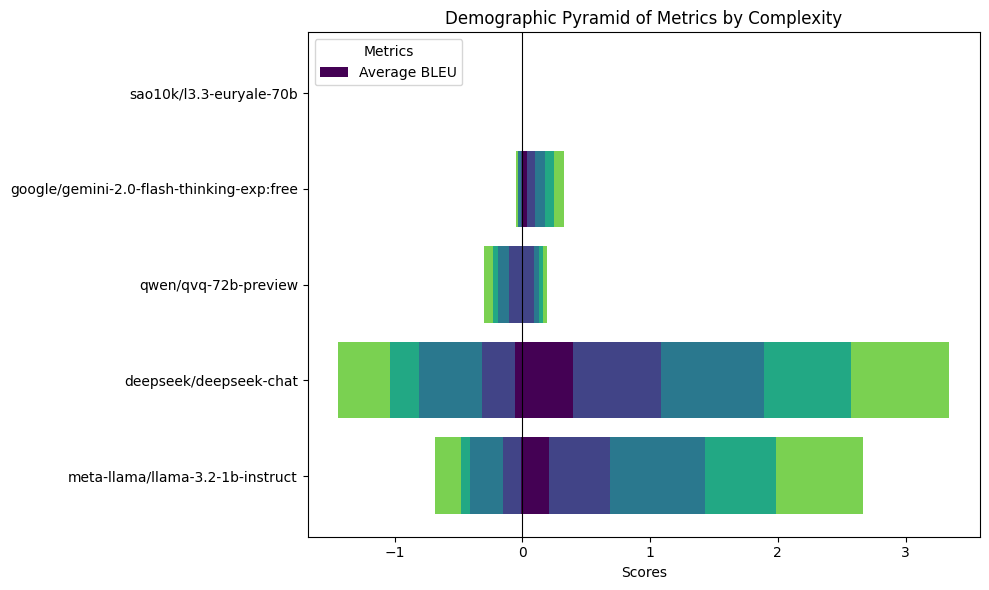

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Пример данных
data = {
    "Model": [
        "meta-llama/llama-3.2-1b-instruct",
        "deepseek/deepseek-chat",
        "qwen/qvq-72b-preview",
        "google/gemini-2.0-flash-thinking-exp:free",
        "sao10k/l3.3-euryale-70b",
        "meta-llama/llama-3.2-1b-instruct",
        "deepseek/deepseek-chat",
        "qwen/qvq-72b-preview",
        "google/gemini-2.0-flash-thinking-exp:free",
        "sao10k/l3.3-euryale-70b"
    ],
    "Average BLEU": [0.209649, 0.400316, 0.005466, 0.037817, 0.000000,
                     0.010663, 0.059309, 0.004901, 0.000733, 0.000000],
    "Average METEOR": [0.479784, 0.681937, 0.089474, 0.065801, 0.000000,
                       0.140239, 0.259102, 0.096647, 0.011063, 0.000000],
    "Average ROUGE-1": [0.738945, 0.809426, 0.036557, 0.077112, 0.003704,
                        0.254980, 0.491485, 0.088634, 0.018685, 0.000000],
    "Average ROUGE-2": [0.559403, 0.680252, 0.027601, 0.066963, 0.000000,
                        0.072763, 0.222664, 0.039305, 0.005372, 0.000000],
    "Average ROUGE-L": [0.677429, 0.771990, 0.035239, 0.075524, 0.003704,
                        0.208111, 0.408464, 0.071687, 0.014535, 0.000000],
    "complexity": [
        "different/", "different/", "different/", "different/", "different/",
        "more 10 tables", "more 10 tables", "more 10 tables", "more 10 tables", "more 10 tables"
    ]
}

df = pd.DataFrame(data)

# Разделяем данные по категориям
different = df[df["complexity"] == "different/"]
more_10_tables = df[df["complexity"] == "more 10 tables"]

# Метрики
metrics = ["Average BLEU", "Average METEOR", "Average ROUGE-1", "Average ROUGE-2", "Average ROUGE-L"]

# Генерируем массив для накопительных данных
different_stacks = np.cumsum(different[metrics], axis=1)
more_10_tables_stacks = np.cumsum(more_10_tables[metrics], axis=1)

# Построение графика
fig, ax = plt.subplots(figsize=(10, 6))

# Горизонтальные полосы для complexity="different/"
for i, metric in enumerate(metrics):
    ax.barh(different["Model"], different[metric], left=different_stacks.iloc[:, i - 1] if i > 0 else 0,
            color=plt.cm.viridis(i / len(metrics)), label=metric if i == 0 else "")

# Горизонтальные полосы для complexity="more 10 tables"
for i, metric in enumerate(metrics):
    ax.barh(more_10_tables["Model"], -more_10_tables[metric],
            left=-more_10_tables_stacks.iloc[:, i - 1] if i > 0 else 0,
            color=plt.cm.viridis(i / len(metrics)))

# Настройка графика
ax.set_xlabel("Scores")
ax.set_title("Demographic Pyramid of Metrics by Complexity")
ax.axvline(0, color="black", linewidth=0.8)
ax.legend(title="Metrics", loc="upper left")
plt.tight_layout()

# Отображение графика
plt.show()


<ipython-input-10-aa0770aa5f59>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma")


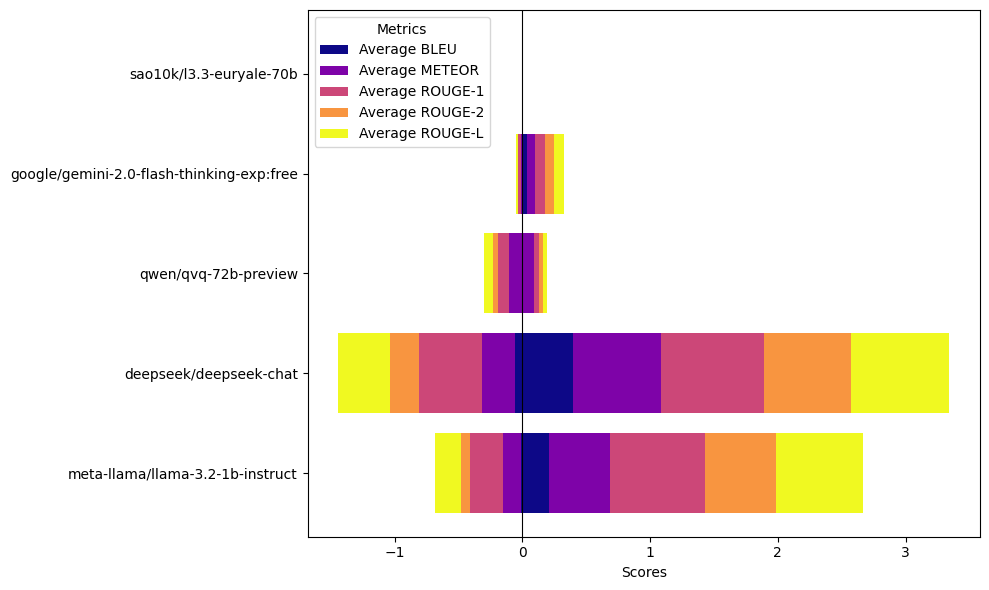

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap

# Пример данных
data = {
    "Model": [
        "meta-llama/llama-3.2-1b-instruct",
        "deepseek/deepseek-chat",
        "qwen/qvq-72b-preview",
        "google/gemini-2.0-flash-thinking-exp:free",
        "sao10k/l3.3-euryale-70b",
        "meta-llama/llama-3.2-1b-instruct",
        "deepseek/deepseek-chat",
        "qwen/qvq-72b-preview",
        "google/gemini-2.0-flash-thinking-exp:free",
        "sao10k/l3.3-euryale-70b"
    ],
    "Average BLEU": [0.209649, 0.400316, 0.005466, 0.037817, 0.000000,
                     0.010663, 0.059309, 0.004901, 0.000733, 0.000000],
    "Average METEOR": [0.479784, 0.681937, 0.089474, 0.065801, 0.000000,
                       0.140239, 0.259102, 0.096647, 0.011063, 0.000000],
    "Average ROUGE-1": [0.738945, 0.809426, 0.036557, 0.077112, 0.003704,
                        0.254980, 0.491485, 0.088634, 0.018685, 0.000000],
    "Average ROUGE-2": [0.559403, 0.680252, 0.027601, 0.066963, 0.000000,
                        0.072763, 0.222664, 0.039305, 0.005372, 0.000000],
    "Average ROUGE-L": [0.677429, 0.771990, 0.035239, 0.075524, 0.003704,
                        0.208111, 0.408464, 0.071687, 0.014535, 0.000000],
    "complexity": [
        "different/", "different/", "different/", "different/", "different/",
        "more 10 tables", "more 10 tables", "more 10 tables", "more 10 tables", "more 10 tables"
    ]
}

df = pd.DataFrame(data)

# Разделяем данные по категориям
different = df[df["complexity"] == "different/"]
more_10_tables = df[df["complexity"] == "more 10 tables"]

# Метрики
metrics = ["Average BLEU", "Average METEOR", "Average ROUGE-1", "Average ROUGE-2", "Average ROUGE-L"]

# Используем колормап plasma
cmap = get_cmap("plasma")
colors = [cmap(i / (len(metrics) - 1)) for i in range(len(metrics))]

# Генерируем массив для накопительных данных
different_stacks = np.cumsum(different[metrics], axis=1)
more_10_tables_stacks = np.cumsum(more_10_tables[metrics], axis=1)

# Построение графика
fig, ax = plt.subplots(figsize=(10, 6))

# Горизонтальные полосы для complexity="different/"
for i, metric in enumerate(metrics):
    ax.barh(different["Model"], different[metric], left=different_stacks.iloc[:, i - 1] if i > 0 else 0,
            color=colors[i], label=metric)

# Горизонтальные полосы для complexity="more 10 tables"
for i, metric in enumerate(metrics):
    ax.barh(more_10_tables["Model"], -more_10_tables[metric],
            left=-more_10_tables_stacks.iloc[:, i - 1] if i > 0 else 0,
            color=colors[i])

# Настройка графика
ax.set_xlabel("Scores")
ax.axvline(0, color="black", linewidth=0.8)
ax.legend(title="Metrics", loc="upper left")
plt.tight_layout()

# Отображение графика
plt.show()


<ipython-input-13-eec1630a7c78>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma")


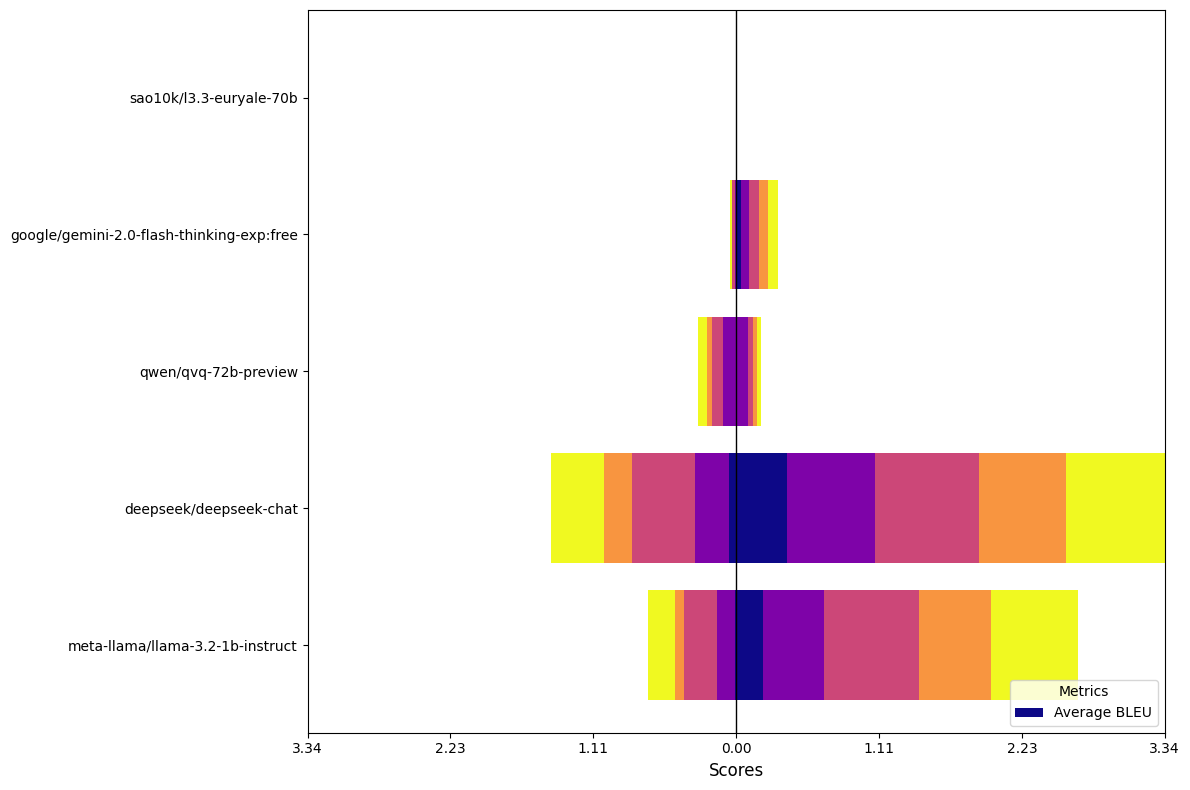

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap

# Пример данных
data = {
    "Model": [
        "meta-llama/llama-3.2-1b-instruct",
        "deepseek/deepseek-chat",
        "qwen/qvq-72b-preview",
        "google/gemini-2.0-flash-thinking-exp:free",
        "sao10k/l3.3-euryale-70b",
        "meta-llama/llama-3.2-1b-instruct",
        "deepseek/deepseek-chat",
        "qwen/qvq-72b-preview",
        "google/gemini-2.0-flash-thinking-exp:free",
        "sao10k/l3.3-euryale-70b"
    ],
    "Average BLEU": [0.209649, 0.400316, 0.005466, 0.037817, 0.000000,
                     0.010663, 0.059309, 0.004901, 0.000733, 0.000000],
    "Average METEOR": [0.479784, 0.681937, 0.089474, 0.065801, 0.000000,
                       0.140239, 0.259102, 0.096647, 0.011063, 0.000000],
    "Average ROUGE-1": [0.738945, 0.809426, 0.036557, 0.077112, 0.003704,
                        0.254980, 0.491485, 0.088634, 0.018685, 0.000000],
    "Average ROUGE-2": [0.559403, 0.680252, 0.027601, 0.066963, 0.000000,
                        0.072763, 0.222664, 0.039305, 0.005372, 0.000000],
    "Average ROUGE-L": [0.677429, 0.771990, 0.035239, 0.075524, 0.003704,
                        0.208111, 0.408464, 0.071687, 0.014535, 0.000000],
    "complexity": [
        "different/", "different/", "different/", "different/", "different/",
        "more 10 tables", "more 10 tables", "more 10 tables", "more 10 tables", "more 10 tables"
    ]
}

df = pd.DataFrame(data)

# Разделяем данные по категориям
different = df[df["complexity"] == "different/"]
more_10_tables = df[df["complexity"] == "more 10 tables"]

# Метрики
metrics = ["Average BLEU", "Average METEOR", "Average ROUGE-1", "Average ROUGE-2", "Average ROUGE-L"]

# Используем колормап plasma
cmap = get_cmap("plasma")
colors = [cmap(i / (len(metrics) - 1)) for i in range(len(metrics))]

# Генерируем массив для накопительных данных
different_stacks = np.cumsum(different[metrics], axis=1)
more_10_tables_stacks = np.cumsum(more_10_tables[metrics], axis=1)

# Построение графика
fig, ax = plt.subplots(figsize=(12, 8))

# Горизонтальные полосы для complexity="different/" (слева)
for i, metric in enumerate(metrics):
    ax.barh(different["Model"], different[metric],
            left=different_stacks.iloc[:, i - 1] if i > 0 else 0,
            color=colors[i], label=metric if i == 0 else "")

# Горизонтальные полосы для complexity="more 10 tables" (справа)
for i, metric in enumerate(metrics):
    ax.barh(more_10_tables["Model"], -more_10_tables[metric],
            left=-more_10_tables_stacks.iloc[:, i - 1] if i > 0 else 0,
            color=colors[i])

# Настройка графика
ax.set_xlabel("Scores", fontsize=12)
ax.axvline(0, color="black", linewidth=1.0)

# Устанавливаем симметричный диапазон оси X
x_max = max(different_stacks.max().max(), more_10_tables_stacks.max().max())
ax.set_xlim(-x_max, x_max)

# Изменяем подписи оси X
xticks = np.linspace(-x_max, x_max, 7)
xticks_labels = [f"{abs(x):.2f}" for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks_labels)

# Легенда
ax.legend(title="Metrics", loc="lower right", fontsize=10)
plt.tight_layout()

# Отображение графика
plt.show()
